# Periodic Orbital MCMC

Illustrating the usage of Algorithm 2 of [Neklyudov & Welling, (2021)](https://arxiv.org/abs/2010.08047) on the Banana density 

$$p(x) = p(x_1, x_2) = N(x_1|0, 8)N(x_2|1/4x_1^2, 1).$$ 

Bijection functions $f(x, v)$ used for sampling are the velocity Verlet, McLachlan and Yoshida integrators for the Hamiltonian function

$$ H(x, v) = \frac{1}{2}\left(\frac{x_1^2}{8} + \left(x_2 - \frac{1}{4}x_1^2\right)^2\right) + \frac{1}{2}v^Tv. $$

Using any of these integrators amounts to doing vanilla HMC (traditionally done with the velocity Verlet integrator) but sampling various points from an orbit that discretizes the Hamiltonian dynamics to then weigh these samples in order to ensure we target the correct distribution (where in vanilla HMC we would choose a sample from the discretized orbit and perform a Metropolis-Hastings acceptance step on that sample to ensure the target distribution is left invariant).

The benefits of sampling the whole orbit instead of a single point in it are: efficiency, since we build a trajectory around an orbit and use all if it instead of discarding most of it; and wider reach, since even unlikely points will be sampled and given small weights, making the sampler more likely to explore the tails of our target. This at the cost of higher memory consumption since we have `period` samples per iteration, instead of only one, and the lack of diagnostics, theoretical guarantees and heuristic methods developed for traditional HMC and its adaptive mechanisms (such as NUTS) during the past decades.

It is also illustrated the usage of normalizing flows, specifically the Masked Autoregressive flow ([MAF](https://arxiv.org/abs/1705.07057)), as a preconditioning step for the algorithm; using as a bijection function the ellipsis

$$ 
x(t) = x(0) \cos(t) + v(t) \sin(t) \\
v(t) = v(0) \cos(t) - x(t) \sin(t),
$$

i.e. the solution of Hamilton's equations for $p(x,v) = N(x|0,I)N(v|0,I)$,

$$
\frac{d x}{d t} = v \\
\frac{d v}{d t} = -x.
$$

As it is later demonstrated, these dynamics alone fail to capture all the volume of our banana density. They are, however, cheap and easy to use, since these dynamics are both gradient-free (don't require the computation of gradients of our target distribution) and tuning-free (have no tuning parameters); in contrast with the integrators mentioned above, which need to compute gradients at each iteration and require tuning of the discretization step size and number of steps (when used for periodic orbital MCMC, these values are represented by the `step_size` and `period`). Paired with a preconditioning step which transforms our target to approximate $N(x|0,I)$, our cheap and easy dynamics can efficienty sample from the whole volume of our banana density while delegating the expensive gradients and cumbersome tuning to an optimization problem performed pre-sampling.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt

import blackjax.mcmc.integrators as integrators
from blackjax import orbital_hmc as orbital

In [2]:
%load_ext watermark
%watermark -d -m -v -p jax,jaxlib,blackjax

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

jax     : 0.3.8
jaxlib  : 0.3.7
blackjax: 0.5.0

Compiler    : GCC 11.2.1 20220127 (Red Hat 11.2.1-9)
OS          : Linux
Release     : 5.17.4-200.fc35.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
jax.devices()

[CpuDevice(id=0)]

## Useful functions

In [4]:
def plot_contour(logprob, orbits=None, weights=None):
    """Contour plots for density w/ or w/o samples."""
    a, b, c, d = -7.5, 7.5, -5, 12.5
    x1 = jnp.linspace(a, b, 1000)
    x2 = jnp.linspace(c, d, 1000)
    y = jax.vmap(
        jax.vmap(lambda x1, x2: jnp.exp(logprob({"x1": x1, "x2": x2})), (0, None)),
        (None, 0),
    )(x1, x2)
    fig, ax = plt.subplots(1, 2, figsize=(17, 6))
    CS0 = ax[0].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS0, inline=1, fontsize=10)
    CS1 = ax[1].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS1, inline=1, fontsize=10)
    if orbits is not None:
        ax[0].set_title("Unweighted samples")
        ax[0].scatter(orbits["x1"], orbits["x2"], marker=".")
        ax[1].set_title("Weighted samples")
        ax[1].scatter(orbits["x1"], orbits["x2"], marker=".", alpha=weights)

In [5]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    """Sequantially draws samples given the kernel of choice."""

    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Banana density

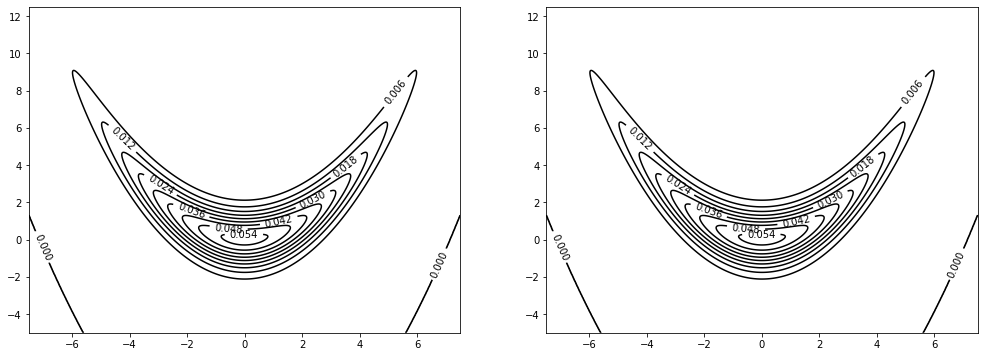

In [6]:
def logprob_fn(x1, x2):
    """Banana density"""
    return stats.norm.logpdf(x1, 0.0, jnp.sqrt(8.0)) + stats.norm.logpdf(
        x2, 1 / 4 * x1**2, 1.0
    )


logprob = lambda x: logprob_fn(**x)
plot_contour(logprob)

## Initial state and sampler parameters

Since the algorithm doesn't have an accept/reject step, we can't tune the parameters of the bijection according to its acceptance probability. By weighing the samples we are are doing, in a sense, importance sampling; hence, an alternative would be develop and adaptive procedure that aims at reducing the variance of the weights. 

The algorithm samples orbits of length `period`. Each iteration, starting from an initial point sampled from the previous orbit, shifts its initial point's position in the orbit, hence making the algorithm irreversible, and samples the whole orbit, forwards and backwards in order to cover the whole period, for steps of length `step_size`. The samples are then weighted and returned with its corresponding weights.

In [7]:
inv_mass_matrix = jnp.ones(2)
period = 10
step_size = 1e-1

In [8]:
initial_position = {"x1": 0.0, "x2": 0.0}

## Velocity Verlet

The integrator usually found in implementations of HMC. It creates an orbit by discretizing the solution to Hamilton's equations of the Hamiltonian function 

$$ H(x, v) = \frac{1}{2}\left(\frac{x_1^2}{8} + \left(x_2 - \frac{1}{4}x_1^2\right)^2\right) + \frac{1}{2}v^Tv .$$

The plots include the unweighted samples to get an idea of how the integrator is exploring the sample space before the weight's "correction".

In [9]:
%%time
init_fn, vv_kernel = orbital(
    logprob, step_size, inv_mass_matrix, period, bijection=integrators.velocity_verlet
)
initial_state = init_fn(initial_position)
vv_kernel = jax.jit(vv_kernel)

CPU times: user 183 ms, sys: 1.19 ms, total: 184 ms
Wall time: 183 ms


In [10]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, vv_kernel, initial_state, 10_000)

samples = states.positions
weights = states.weights

CPU times: user 646 ms, sys: 5.98 ms, total: 652 ms
Wall time: 643 ms


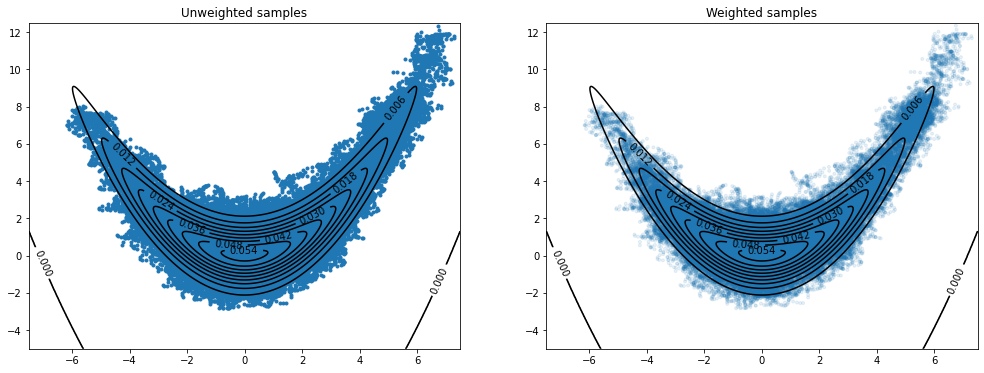

In [11]:
plot_contour(logprob, orbits=samples, weights=weights)

## McLachlan

A different method of discretizing the solution to Hamilton's equations, see [Blanes, Casas & Sanz-Serna (2014)](https://arxiv.org/abs/1405.3153)

In [12]:
%%time
init_fn, ml_kernel = orbital(
    logprob, step_size, inv_mass_matrix, period, bijection=integrators.mclachlan
)
initial_state = init_fn(initial_position)
ml_kernel = jax.jit(ml_kernel)

CPU times: user 6.8 ms, sys: 886 µs, total: 7.69 ms
Wall time: 7.33 ms


In [13]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, ml_kernel, initial_state, 10_000)

samples = states.positions
weights = states.weights

CPU times: user 536 ms, sys: 5.71 ms, total: 542 ms
Wall time: 532 ms


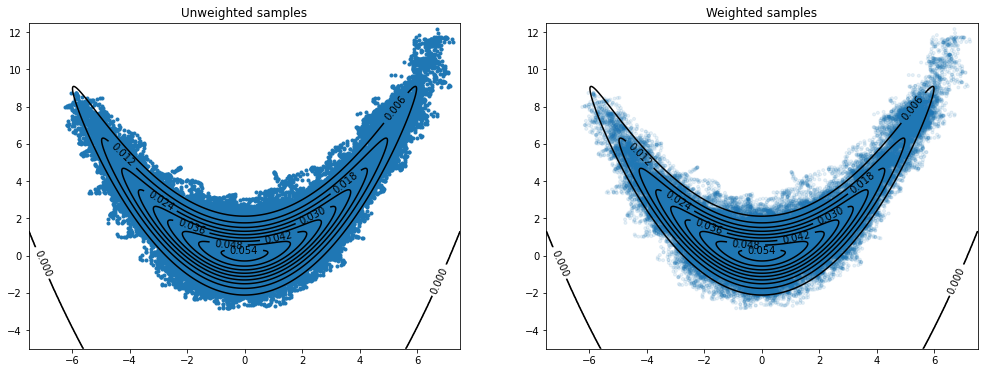

In [14]:
plot_contour(logprob, orbits=samples, weights=weights)

## Yoshida

A different method of discretizing the solution to Hamilton's equations, see [Blanes, Casas & Sanz-Serna (2014)](https://arxiv.org/abs/1405.3153)

In [15]:
%%time
init_fn, yo_kernel = orbital(
    logprob, step_size, inv_mass_matrix, period, bijection=integrators.yoshida
)
initial_state = init_fn(initial_position)
yo_kernel = jax.jit(yo_kernel)

CPU times: user 6.54 ms, sys: 1.26 ms, total: 7.8 ms
Wall time: 7.1 ms


In [16]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, yo_kernel, initial_state, 10_000)

samples = states.positions
weights = states.weights

CPU times: user 585 ms, sys: 333 µs, total: 586 ms
Wall time: 578 ms


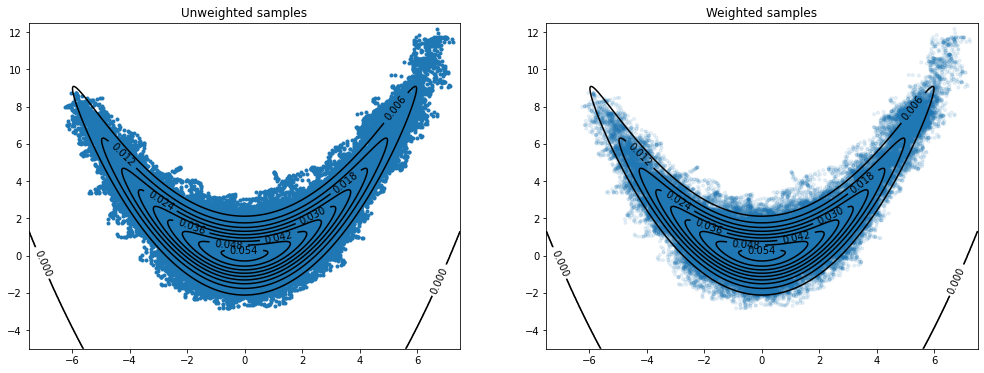

In [17]:
plot_contour(logprob, orbits=samples, weights=weights)

## Ellipsis

We now create and use a bijection given by an ellipsis using the `IntegratorState` class. The bijection must have as inputs the potential and kinetic energy functions, which are the negative log densities of our target posterior and the auxiliary distribution used for the momentum variable. In the case of our banana density, we are targeting the "posterior" $N(x_1|0, 8)N(x_2|1/4x_1^2, 1)$ and using a standard normal distribution for our momentum variable, hence our potential and kinetic energies are $1/2\left(x_1^2/8 + \left(x_2 - 1/4x_1^2\right)^2\right)$ and $1/2v^Tv$, respectively. However, the orbit we build now is independent of these two energies and moves around an ellipsis given by 

$$ 
x(t) = x(0) \cos(t) + v(t) \sin(t) \\
v(t) = v(0) \cos(t) - x(t) \sin(t),
$$

which returns to its initial position every $t=2\pi$ radians. The `step_size` for this orbit is set to cover the entire ellipsis. This ellipsis actually targets a potential and kinetic energy given by the product measure of two standard normal distributions, hence its inefficiency at exploring the real target measure.

The bijection must output a function which takes as input an `IntegratorState`, composed of a position, momentum, potential energy (negative log density of our target evaluated at position) and the gradient of the potential energy, and a step size; and outputs a proposed `IntegratorState`. Even if the dynamics of our bijection are independent of the real potential energy, we need to return the potential energy at the proposed position for the computation of the sampler's weights. But, as our dynamics are gradient-free, we can return the same gradient as the previous state to avoid unnecessary computations.

In [18]:
def elliptical_bijection(potential_fn, kinetic_energy_fn):
    def one_step(
        state: integrators.IntegratorState, step_size: float
    ) -> integrators.IntegratorState:
        _position, _momentum, _, grad = state

        position = jax.tree_util.tree_map(
            lambda position, momentum: position * jnp.cos(step_size)
            + momentum * jnp.sin(step_size),
            _position,
            _momentum,
        )

        momentum = jax.tree_util.tree_map(
            lambda position, momentum: momentum * jnp.cos(step_size)
            - position * jnp.sin(step_size),
            _position,
            _momentum,
        )

        return integrators.IntegratorState(
            position,
            momentum,
            potential_fn(position),
            grad,
        )

    return one_step


step_size = 2 * jnp.pi / period

In [19]:
%%time
init_fn, ellip_kernel = orbital(
    logprob, step_size, inv_mass_matrix, period, bijection=elliptical_bijection
)
initial_state = init_fn(initial_position)
ellip_kernel = jax.jit(ellip_kernel)

CPU times: user 7.88 ms, sys: 958 µs, total: 8.83 ms
Wall time: 8.22 ms


In [20]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, ellip_kernel, initial_state, 10_000)

samples = states.positions
weights = states.weights

CPU times: user 492 ms, sys: 4.91 ms, total: 496 ms
Wall time: 489 ms


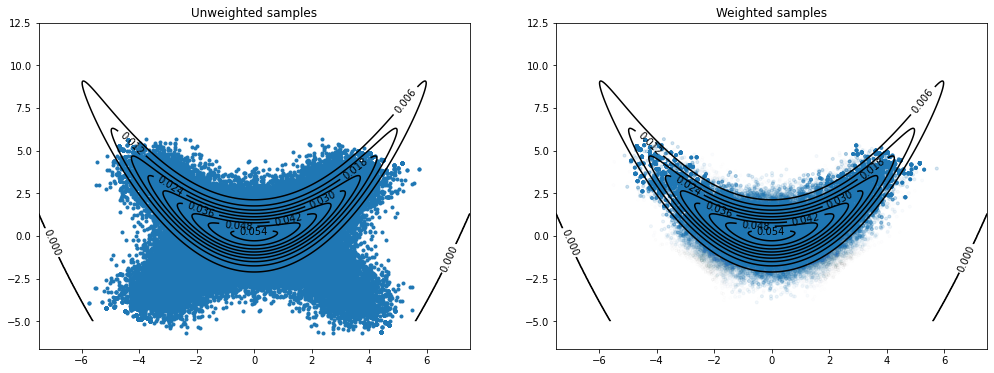

In [21]:
plot_contour(logprob, orbits=samples, weights=weights)

## Ellipsis + IAF

The ellipsis used to build the orbit on the previous algorithm solves Hamilton's equations for $p(x,v) = N(x|0,I)N(v|0,I)$. We can use normalizing flows to approximate the pullback density of our target to a standard normal, thus allowing the algorithm to sample from a density similar to what it is targeting.

To do this we parametrize a diffeomorphism as an [MAF](https://arxiv.org/abs/1705.07057) and optimize its parameters by minimizing the the Kullback-Liebler divergence between the pullback density and a standard normal (equivalently maximizing the Evidence Lower BOund (ELBO) or the Variational Lower Bound).

Once we have a diffeomorphism that "transports" our target to something close enough to a standard normal, we can use our orbital MCMC sampler travelling around the ellipsis to sample from our target pullback density (the target density "transported" to a standard normal). This will be equivalent to sampling using periodic orbital MCMC where the bijection used to move around the orbit is the composition of: first the inverse diffeomorphism which transports samples from our target to the standard normal, then the ellipsis solving Hamilton's equations for $p(x,v) = N(x|0,I)N(v|0,I)$, and finally the diffeomorphism which transports standard normal samples back to samples from our target. Formally, if there is a smooth, invertible transformation $T$ such that for $x$, a random variable distributed as our target density $\pi(x)$, we have that

$$
z \sim \phi(z), \quad x \approx T(z),
$$

where $\phi(z)$ indicates the standard normal density. This implies that

$$
\phi(z) \approx \pi(T(z)) |\det \nabla T(z)|,
$$

where the right hand side of the equation is what we call the pullback density of our target. Thus, letting the bijection $f(x,v) = (x(t), v(t))$ for

$$ 
x(t) = x(0) \cos(t) + v(t) \sin(t) \\
v(t) = v(0) \cos(t) - x(t) \sin(t),
$$

we have that using the periodic orbital MCMC on the pullback with bijection $f(x,v)$ is equivalent to using the periodic orbital MCMC on our target density with bijection $T \circ f \circ T^{-1}$.

First we define our parametrized MAF bijection using autoregressive neural networks.

In [22]:
import optax
from numpyro.nn import AutoregressiveNN

In [23]:
iaf_hidden_dims = [2, 2]
iaf_nonlinearity = jax.example_libraries.stax.Elu
init_fun, apply_fun = AutoregressiveNN(
    2, iaf_hidden_dims, nonlinearity=iaf_nonlinearity
)

Then we initialize the parameters of our MAF transformation and define our reference density as a standard normal.

In [24]:
_, unraveler = jax.flatten_util.ravel_pytree(initial_position)
_, initial_parameters = init_fun(jax.random.PRNGKey(1), (2,))

In [25]:
log_reference = lambda z: jnp.sum(stats.norm.logpdf(z, loc=0.0, scale=1.0))

#### Some utility functions

Define the log pullback density, our loss function (negative ELBO) and the optimization loop used to train our transformation.

In [26]:
def logpullback(params, z):
    mean, log_sd = apply_fun(params, z)
    x = jnp.exp(log_sd) * z + mean
    return logprob(unraveler(x)) + jnp.sum(log_sd)

In [27]:
def nelbo_loss(param, Z, log_pullback, lognorm):
    return -jnp.sum(jax.vmap(log_pullback, (None, 0))(param, Z) - lognorm)

In [28]:
def param_optim(
    rng, init_param, log_pullback, learning_rate, n_iter, n_atoms, n_epochs
):
    epoch_size, remainder = jnp.divmod(n_iter, n_epochs)
    n_iter = epoch_size + jnp.bool_(remainder)
    rngs = jax.random.split(rng, n_epochs)

    optimizer = optax.adam(learning_rate=learning_rate)
    init_state = optimizer.init(init_param)

    def _epoch(carry, rng):
        state, params = carry
        Z = jax.random.normal(rng, (n_atoms, 2))
        lognorm = jax.vmap(log_reference)(Z)

        def _iter(carry, _):
            state, params = carry
            grads = jax.grad(nelbo_loss)(params, Z, log_pullback, lognorm)
            updates, state = optimizer.update(grads, state)
            params = optax.apply_updates(params, updates)
            nelbo = nelbo_loss(params, Z, log_pullback, lognorm)
            return (state, params), nelbo

        (_, params), nelbo = jax.lax.scan(_iter, (state, params), jnp.arange(n_iter))
        return (state, params), nelbo

    (_, params), nelbo = jax.lax.scan(_epoch, (init_state, init_param), rngs)
    return params, nelbo.flatten()

We train the parameters of our transformation by minimizing the negative ELBO. A plot of the loss shows convergence.

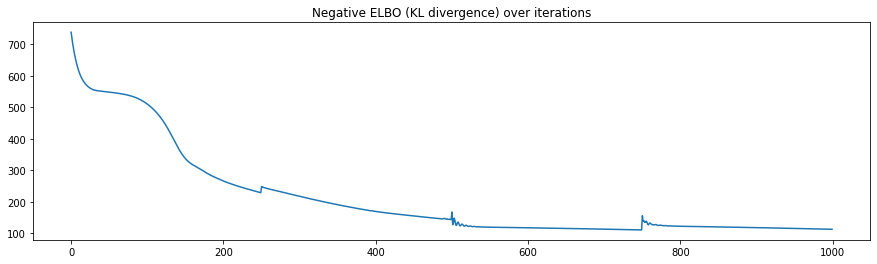

CPU times: user 1.32 s, sys: 84.8 ms, total: 1.4 s
Wall time: 1.3 s


In [29]:
%%time
parameters, nelbo = param_optim(
    jax.random.PRNGKey(0),
    initial_parameters,
    logpullback,
    learning_rate=0.01,
    n_iter=1000,
    n_atoms=1000,
    n_epochs=4,
)
plt.figure(figsize=(15, 4))
plt.title("Negative ELBO (KL divergence) over iterations")
plt.plot(nelbo)
plt.show()

We define our log pullback given the learned parameters of the transformation and use the periodic orbital MCMC with an ellipsis to sample from this log pullback density.

In [30]:
logpullback_fn = lambda x1, x2: logpullback(parameters, jnp.array([x1, x2]))
logpull = lambda z: logpullback_fn(**z)

In [31]:
%%time
init_fn, ellip_kernel = orbital(
    logpull, step_size, inv_mass_matrix, period, bijection=elliptical_bijection
)
initial_state = init_fn(initial_position)
ellip_kernel = jax.jit(ellip_kernel)

CPU times: user 524 ms, sys: 149 ms, total: 673 ms
Wall time: 498 ms


In [32]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, ellip_kernel, initial_state, 10_000)

pullback_samples = states.positions
weights = states.weights

CPU times: user 629 ms, sys: 689 µs, total: 630 ms
Wall time: 624 ms


We need to push the samples through the learned MAF transformation to have samples from the target density (banana) and not the pullback.

In [33]:
def push_samples(z1, z2):
    z = jnp.array([z1, z2])
    mean, log_sd = apply_fun(parameters, z)
    x = jnp.exp(log_sd) * z + mean
    return x[0], x[1]

In [34]:
samplesx1, samplesx2 = jax.vmap(jax.vmap(push_samples))(
    pullback_samples["x1"], pullback_samples["x2"]
)
samples = {"x1": samplesx1, "x2": samplesx2}

The pushed samples are much better at targeting the banana density than the algorithm without a preconditioning step. The transformation helps the sampler stay close to the same density level when moving around the ellipsis, thus reducing the variance of the step's weights along it. This preconditioning serves, in a way, as an adaptive step that tunes the parameters of the sampler through a transformation. Notice that if we move around the whole ellipsis there are no tuning parameters, only the number of samples we choose to extract at each iteration, in contrast with choosing step sizes and number of steps in the case of the other numerical integrators. Of course, we still need to choose a gradient descent algorithm, learning rates, number of iterations, and epochs for the optimization!

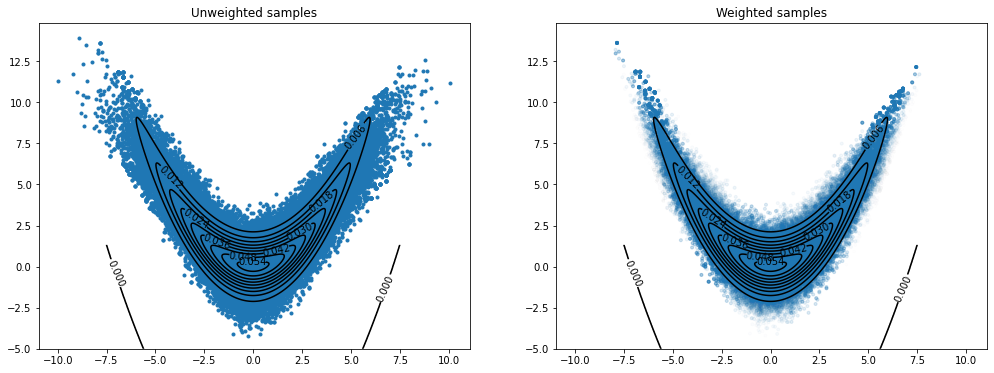

In [35]:
plot_contour(logprob, orbits=samples, weights=weights)